# Trapped Ion Qubits

These examples all cover dynamical simulation of trapped ion qubits. These examples use small systems, but note that the GPU will only provide an advantage for systems with total dimension of O(1000). 

## GHZ state
This example shows how to prepare a GHZ (`Greenberger-Horne-Zeilinger`) state using trapped ions and CUDA-Q. We'll use the effective spin model from the famous `Sørensen-Mølmer` [paper.](https://www.quantumoptics.at/images/publications/dissertation/ThesisMvM_Web.pdf)

Running time evolution...

Results at GHZ time (χt = 0.393):
P(|gggggggg⟩) = 0.500
P(|eeeeeeee⟩) = 0.500
Total in extremes: 0.999
GHZ state quality: 1.000 (1.0 = perfect)
Perfect GHZ would have P(gg) = P(ee) = 0.5


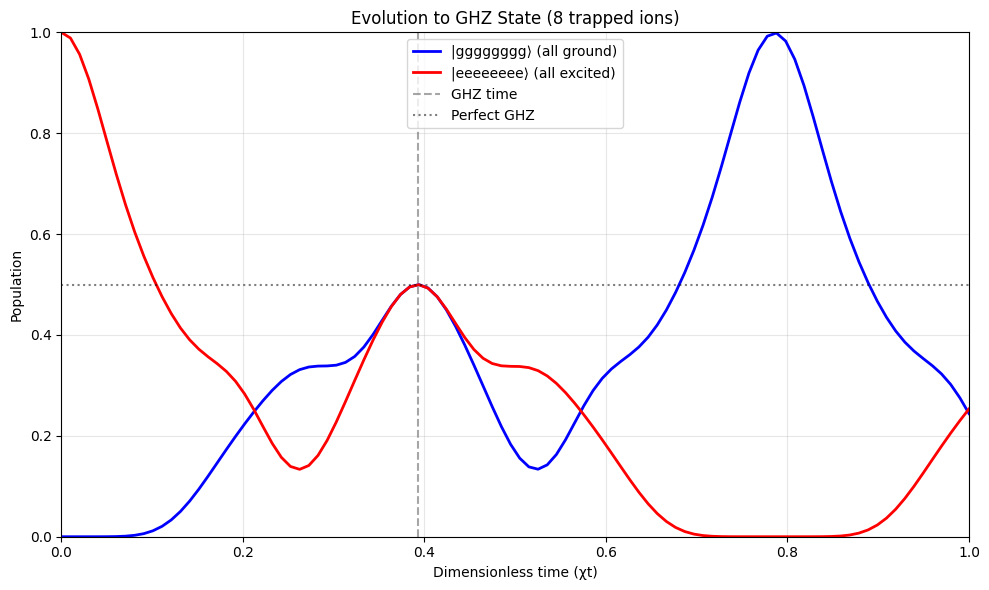

In [1]:
"""
What we're doing:
- Start with N ions all in ground state `|gg...g⟩`
- Apply an effective Hamiltonian H = 4χJ_x²  
- Watch the system evolve into a GHZ superposition: `(|gg...g⟩ + |ee...e⟩)/√2`

This tutorial uses the simplified effective model (`Eq. 2` from the paper).
"""

import cudaq
from cudaq import spin, Schedule, RungeKuttaIntegrator
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt

cudaq.set_target("dynamics")

# Physical parameters, these come from the `Sørensen-Mølmer` paper
nu = 1.0  # Trap frequency (our reference)
delta = 0.9 * nu  # Laser detuning
Omega = 0.1 * nu  # Laser strength
eta = 0.1  # How strongly lasers couple to motion

# The effective coupling strength (this is the key parameter!)
chi = (eta**2 * Omega**2 * nu) / (2 * (nu**2 - delta**2))

N = 8  # Number of ions (start small!)
evolution_time = 1.0 / chi  # How long to evolve
num_steps = 100  # Time resolution

dimensions = {i: 2 for i in range(N)}  # Each ion is a 2-level system

# collective spin operator J_x
J_x = spin.empty()
for i in range(N):
    J_x += spin.x(i)
J_x /= 2  # Normalize

hamiltonian = 4 * chi * J_x * J_x

# Set up initial state and time evolution
# Start with all ions in ground state `|gg...g⟩`
initial_state_vector = cp.zeros(2**N, dtype=cp.complex128)
initial_state_vector[0] = 1.0  # |00...0⟩ = `|gg...g⟩`
initial_state = cudaq.State.from_data(initial_state_vector)

# Set up time points for evolution
times = np.linspace(0, evolution_time, num_steps)
chi_times = chi * times  # Dimensionless time χt
schedule = Schedule(times, ["t"])

# Create observables to track the populations
# We want to measure the probability of being in `|gg...g⟩` and `|ee...e⟩`

# Projector onto `|gg...g⟩ = |00...0⟩`
P_ground = spin.empty()
for i in range(N):
    if i == 0:
        P_ground = (spin.identity(i) - spin.z(i)) / 2  # `|0⟩⟨0|`
    else:
        P_ground = P_ground * (spin.identity(i) - spin.z(i)) / 2

# Projector onto `|ee...e⟩ = |11...1⟩`
P_excited = spin.empty()
for i in range(N):
    if i == 0:
        P_excited = (spin.identity(i) + spin.z(i)) / 2  # `|1⟩⟨1|`
    else:
        P_excited = P_excited * (spin.identity(i) + spin.z(i)) / 2

observables = [P_ground, P_excited]

# Run the simulation!
print("Running time evolution...")
evolution_result = cudaq.evolve(
    hamiltonian,
    dimensions,
    schedule,
    initial_state,
    observables=observables,
    collapse_operators=[],  # No decoherence for this tutorial
    store_intermediate_results=cudaq.IntermediateResultSave.EXPECTATION_VALUE,  # Save expectation values
    integrator=RungeKuttaIntegrator())

# Extract the results
exp_vals = evolution_result.expectation_values()
pop_ground = [exp_vals[i][0].expectation() for i in range(len(times))]
pop_excited = [exp_vals[i][1].expectation() for i in range(len(times))]

# The GHZ state appears at a special time: χt = π/8
ghz_chi_t = np.pi / 8
ghz_time_idx = np.argmin(np.abs(chi_times - ghz_chi_t))
ghz_pop_ground = pop_ground[ghz_time_idx]
ghz_pop_excited = pop_excited[ghz_time_idx]

print(f"\nResults at GHZ time (χt = {ghz_chi_t:.3f}):")
print(f"P(|{'g'*N}⟩) = {ghz_pop_ground:.3f}")
print(f"P(|{'e'*N}⟩) = {ghz_pop_excited:.3f}")
print(f"Total in extremes: {ghz_pop_ground + ghz_pop_excited:.3f}")

# Check GHZ state quality
# For perfect GHZ state: `P(gg) = P(ee) = 0.5`
ghz_quality = 1 - 2 * abs(
    ghz_pop_ground - 0.5)  # Distance from ideal probability
print(f"GHZ state quality: {ghz_quality:.3f} (1.0 = perfect)")
print(f"Perfect GHZ would have P(gg) = P(ee) = 0.5")

plt.figure(figsize=(10, 6))
plt.plot(chi_times,
         pop_ground,
         'b-',
         linewidth=2,
         label=f"|{'g'*N}⟩ (all ground)")
plt.plot(chi_times,
         pop_excited,
         'r-',
         linewidth=2,
         label=f"|{'e'*N}⟩ (all excited)")
plt.axvline(ghz_chi_t,
            color='gray',
            linestyle='--',
            alpha=0.7,
            label="GHZ time")
plt.axhline(0.5, color='black', linestyle=':', alpha=0.5, label="Perfect GHZ")

plt.xlabel("Dimensionless time (χt)")
plt.ylabel("Population")
plt.title(f"Evolution to GHZ State ({N} trapped ions)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()